<a href="https://colab.research.google.com/github/nidhaloff/Regression-Pytorch/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [242]:
import keras
from keras import backend as K
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

%matplotlib inline

# run keras model on google GPU
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [243]:
dataset = make_regression(n_samples=1000, n_features=1, noise=5, random_state=42)
X, y = dataset
X.shape, y.shape

((1000, 1), (1000,))

In [244]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [245]:
pip install skorch

In [246]:
# implementation only using pytorch

y = y.reshape(-1, 1)
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train_torch = torch.from_numpy(X_train.astype(np.float32))
y_train_torch = torch.from_numpy(y_train.astype(np.float32))
X_test_torch = torch.from_numpy(X_test.astype(np.float32))
y_test_torch = torch.from_numpy(y_test.astype(np.float32))
print(X_train_torch.shape, y_train_torch.shape)


trainset = TensorDataset(X_train_torch, y_train_torch)
testset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)


class Regressor(nn.Module):
    def __init__(self, n_features, n_out):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 100)
        self.fc2 = nn.Linear(100, n_out)
#         self.fc3 = nn.Linear(600, 300)
#         self.fc4 = nn.Linear(300, n_out)
        
    def forward(self, x):
        out = self.fc1(x)
#         out = F.tanh(self.fc2(out))
#         out = F.sigmoid(self.fc3(out))
        out = self.fc2(out)
        return out
    

# model = Regressor(X.shape[1], 1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

def training_func(model, criterion, optimizer):
    def train_step(sample, target):
        model.train()
        optimizer.zero_grad()
        out = model(sample)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        return loss.item()
    return train_step

def fit(epochs=10):
    train_losses, test_losses, accuracy_list = ([] for _ in range(3))
    train = training_func(model=model, criterion=criterion, optimizer=optimizer)
    for e in range(epochs):
        for x, y in train_loader:
            loss_val = train(x, y)
            train_losses.append(loss_val)
            
        else:
            with torch.no_grad():
                model.eval()
                for x_test, y_test in test_loader:
                    pred = model(x_test)
                    loss = criterion(pred, y_test)
                    test_losses.append(loss.item())
                    accuracy = r2_score(y_test.numpy(), pred.numpy())
                    accuracy_list.append(accuracy)
                    
        print(f"Epoch: {e} => average training loss= {sum(train_losses)/ len(train_losses)} average test losses= {sum(test_losses)/ len(test_losses)} and accuracy= {sum(accuracy_list)/ len(accuracy_list)}")
        
    return train_losses, test_losses, accuracy_list
                    

def plot_results(train_losses, test_losses, accs):
    plt.plot(train_losses, color="b")
    plt.title("train losses over time")
    plt.show()
    plt.plot(test_losses, color= "b")
    plt.title("test losses over time")
    plt.show()
    
    plt.plot(accs, color= "b")
    plt.title("Accuracy over time")
    plt.show()
    

# train_losses, test_losses, accs = fit(10)
# plot_results(train_losses, test_losses, accs)
# print("final train loss value = ", train_losses[-1])
# print("final test loss value = ", test_losses[-1])
# print("final accuracy of the model => ", accs[-1])


(1000, 1) (1000, 1)
torch.Size([800, 1]) torch.Size([800, 1])


In [0]:
import skorch
from skorch import NeuralNet

In [0]:
net = NeuralNet(module=model, criterion=nn.MSELoss, optimizer=optim.SGD, 
               lr=1e-3, max_epochs=20, batch_size=64)

In [267]:
net.fit(X_train_torch, y_train_torch)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       24.3828       22.6195  0.0222
      2       24.3784       22.6554  0.0151
      3       24.3775       22.6718  0.0172
      4       24.3773       22.6791  0.0170
      5       24.3772       22.6823  0.0180
      6       24.3772       22.6838  0.0173
      7       24.3772       22.6844  0.0174
      8       24.3772       22.6847  0.0174
      9       24.3772       22.6848  0.0173
     10       24.3772       22.6849  0.0199
     11       24.3772       22.6849  0.0168
     12       24.3772       22.6849  0.0172
     13       24.3772       22.6849  0.0169
     14       24.3772       22.6849  0.0170
     15       24.3771       22.6849  0.0193
     16       24.3771       22.6849  0.0169
     17       24.3771       22.6849  0.0162
     18       24.3771       22.6849  0.0180
     19       24.3771       22.6849  0.0168
     20       24.3771       22.6849  0.0181


<class 'skorch.net.NeuralNet'>[initialized](
  module_=Regressor(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=1, bias=True)
  ),
)

0.9134428205340318


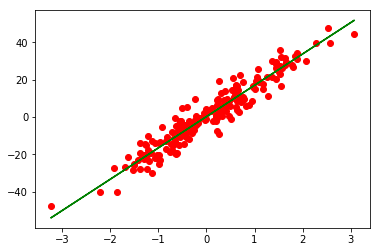

In [271]:
with torch.no_grad():
    net_preds = net.predict(X_test_torch)
    score = r2_score(y_test_torch.detach().numpy(), net_preds)
    print(score)
    plt.scatter(X_test_torch.detach().numpy(), y_test_torch.detach().numpy(), c="r", marker="o")
    plt.plot(X_test_torch.detach().numpy(), net_preds, color="g")